# Tarini's Gekko test for solving OCT

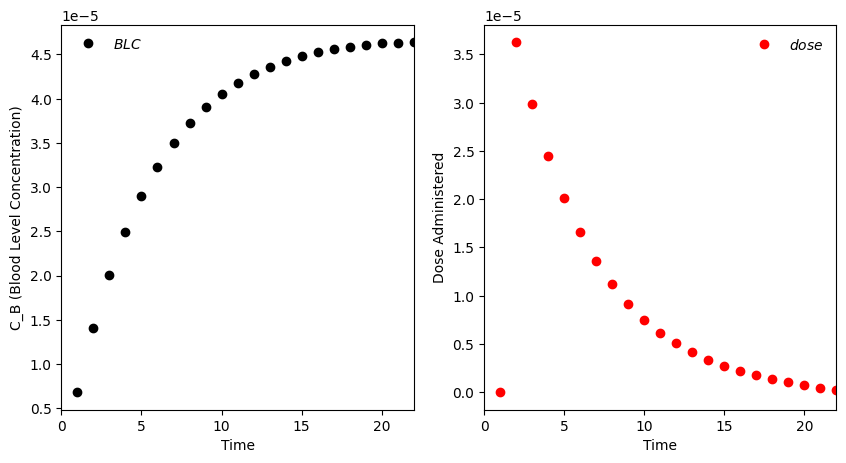

In [48]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
m = GEKKO(remote=True)

# Define the number of time steps and time vector (22 days)
nt = 22
m.time = np.array([i for i in range(1, nt+1)]) 

# State Variables and Parameters
C_B = m.Var(value=6.8e-6)  # Blood concentration in mg/L
#C_target = m.Var() # Blood level concentration in mg/L for SOC / target
M = m.Var(value=0.0)  # Total amount of drug metabolized (mg)
dose = m.Var()  # Drug administered at time t
#D_total = m.Var() # Total drug in body by time t
RC = m.Var(value=0) # Running cost (the integrand of the objective function)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Patient-specific parameters
V_max = 3.5e-12  # Maximum rate (pmol/min/pmol P450)
K_m = 16e-6  # Substrate concentration at half-maximal rate (mol/L)

# Equations 
BV = 5.0  # units: L
m.Equation(C_B.dt() == (dose - M) / BV)  # Rate of change of blood concentration
m.Equation(M.dt() == (V_max * C_B) / (K_m + C_B))  # Michaelis-Menten kinetics
#m.Equation(D_total.dt() == 5)  # Rate of change of total dose 
m.Equation(RC.dt() == -(3.0*(C_B**2) + dose**2)) # Integrand of cost functional 
m.Obj(RC*final) # Objective function

# Solve the optimization problem
m.options.IMODE = 6 # optimal control mode
m.options.MAX_ITER = 1e6
m.options.SOLVER = 1  # APOPT solver+
m.solve(disp=False) # solve

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.ravel()
axes[0].plot(m.time, C_B.value,'ko',label=r'$BLC$')
axes[0].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('C_B (Blood Level Concentration)')
axes[0].set_xlim((0,nt))

axes[1].plot(m.time, dose.value,'ro',label=r'$dose$')
axes[1].legend(loc='best', fancybox=False, shadow=False, frameon=False)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Dose Administered')
axes[1].set_xlim((0,nt))
plt.show()

In [ ]:
# Accumulate doses over time
doses = np.zeros(nt)
dose_interval = [1, 8, 15, 22]  # Days of dose administration (1st, 8th, 15th, 22nd)

# Adjust dosing days to the correct indices (0-based indexing)
BSA = 1.9  # m²
SOC = 1.4  # mg/m² per dose
dose_amount = SOC * BSA  # mg
dose_intervals_adjusted = [i - 1 for i in dose_interval if i <= nt]  # (0th, 7th, 14th, 21st)

# Create dose schedule
for t_dose in dose_intervals_adjusted:
    doses[t_dose] = dose_amount

# Equation for accumulating doses over time (total administered dose)
m.Equation(D_total.dt() == doses[0])  # Start with first dose (initialize it)

for i in range(1, nt):
    m.Equation(D_total.dt() == doses[i] + D_total)  # Accumulate doses over time